In [1]:
import sys, os
sys.path.insert(1, '../python')
sys.path.insert(1, os.path.join(os.environ['GOOGLE_DRIVE'], 'research/packages/vlasov_solver'))
sys.path.insert(1, os.path.join(os.environ['GOOGLE_DRIVE'], 'research/projects/my_dshark/py_dshark'))
import py_dshark

In [2]:
import numpy as np
import scipy.optimize
from scipy.special import hyp2f1
from py_vlasov.util import zp, kzkp, list_to_complex, real_imag, pade
from py_vlasov.wrapper import oblique_wrapper, disp_det, input_gen
from py_vlasov.transport_ratios import transport_ratios
from py_vlasov.follow_parameter import follow_k
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5
mpl.rcParams['xtick.major.width'] = 1.1
mpl.rcParams['ytick.major.width'] = 1.1
mpl.rcParams['xtick.minor.width'] = .8
mpl.rcParams['ytick.minor.width'] = .8
#xtick.major.size     : 3.5      # major tick size in points
#xtick.minor.size     : 2      # minor tick size in points
#xtick.major.width    : 0.8    # major tick width in points
#xtick.minor.width    : 0.6    # minor tick width in points
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
def zk_summers(kappa, x):
    ret = 1j * (kappa**2 - 0.25) / kappa**1.5 / (kappa + 1)
    ret *= hyp2f1(1, 2*kappa+2, kappa+2, 0.5*(1+1j*x/np.sqrt(kappa)))
    return ret
def zk_summers_2(kappa, zeta):
    def f(x, k, m):
        ret = scipy.special.factorial(k+m) / scipy.special.factorial(m)
        power_1j = (1, 1j, -1, -1j)
        ret *= power_1j[(k-m) % 4] * (2 / (x/np.sqrt(k) + 1j))**(k+1-m)
        return ret
    ret = sum([f(zeta, kappa, m) for m in range(0, kappa+1)])
    ret *= -(kappa-.5) / 2 / kappa**1.5 * scipy.special.factorial(kappa) / scipy.special.factorial(2*kappa)
    return ret

def zk_shaaban(kappa, zeta):
    zeta = np.sqrt((kappa-1)/kappa) * zeta
    zk_func = zk_summers if kappa < 16 else zk_summers_2
    ret = (kappa-1)**1.5/(kappa-1.5)/np.sqrt(kappa)*zk_func(kappa-1, zeta)
    return ret

In [4]:
zeta = 10+5j
kappa = 32
print(f'{py_dshark.solver.zk_summers(zeta, kappa):.5g}')
print(f'{zk_summers_2(kappa, zeta):.5g}')
print(f'{zk_summers(kappa, zeta):.5g}')

-0.078811+0.03973j
-0.078811+0.03973j
-0.078811+0.03973j


In [5]:
k = 1 / 43
beta_p = 1.
tc_tp = 1
nc_ne = 0.85
th_tc = 10
kappa = 50
v0c_va = -7
u_h = - v0c_va *nc_ne / (1-nc_ne) / np.sqrt(1836)
print(f'u_h = {u_h:.3g}')
# u_h = 0.6
va_c = 2e-4

def disp_det(k, omega, u_h, kappa, beta_p, tc_tp, th_tc, nc_ne, va_c):
    mu = 1836
    beta_c = beta_p * tc_tp
    beta_h = beta_c * th_tc
    u_c = u_h * (1 - nc_ne) / nc_ne 
    zeta_p = (mu * omega + 1) / k / np.sqrt(mu * beta_p)
    zeta_c = (omega - 1 + u_c * k) / k / np.sqrt(beta_c)
    zeta_h = (omega - 1 - u_h * k) / k / np.sqrt(beta_h)
    Z_p = zp(zeta_p)
    Z_c = zp(zeta_c)
    if kappa < 50:
        Zk_h = zk_shaaban(kappa, zeta_h)
    else:
        Zk_h = zp(zeta_h)
    ret = omega**2 * va_c**2 * mu -k**2
    ret += omega / k / np.sqrt(mu * beta_p) * Z_p
    ret += nc_ne * (omega + u_c * k) / k / np.sqrt(beta_c) * Z_c
    ret += (1 - nc_ne) * (omega - u_h * k) / k / np.sqrt(beta_h) * Zk_h
    return ret * 1e-10

u_h = 0.926


In [6]:
f = lambda k, wrel: real_imag(
    disp_det(k, list_to_complex(wrel), 
             u_h, kappa, beta_p, tc_tp, th_tc, nc_ne, va_c)
)
guess = 1.6 / 1836
wr, wi = scipy.optimize.fsolve(lambda wrel: f(k, wrel), real_imag(guess))
print(f'guess = {guess:.3g}')
print(f'found w = {wr:.3g} + {wi:3g}i')

guess = 0.000871
found w = 0.000832 + -2.6266e-06i


In [7]:
# shaaban_k = np.logspace(np.log10(1/43), 0, 100)
shaaban_k = np.linspace(1/43, 1, 100)

In [8]:
ff = lambda kappa, k, wrel: real_imag(
    disp_det(k, list_to_complex(wrel), 
             u_h, kappa, beta_p, tc_tp, th_tc, nc_ne, va_c)
)


shaaban_disps = {}
for kappa in [4, 6, 8, 16, 32, 50]:
    guess = 1.6 / 1836
    shaaban_disp = []
    for k in shaaban_k:
        wr, wi = scipy.optimize.fsolve(lambda wrel: ff(kappa, k, wrel), real_imag(guess))
        shaaban_disp.append(list_to_complex([wr, wi]))
        guess = shaaban_disp[-1]
    shaaban_disp = np.array(shaaban_disp)    
    shaaban_disps[kappa] = shaaban_disp
    

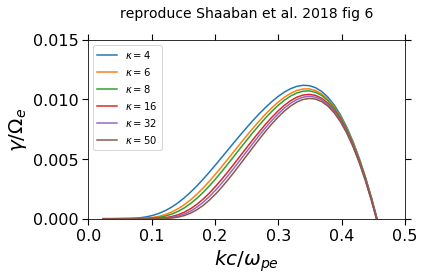

In [9]:
for kappa in [4, 6, 8, 16, 32, 50]:
    shaaban_disp = shaaban_disps[kappa]
    plt.plot(shaaban_k, shaaban_disp.imag, label=f'$\kappa=${kappa}')
plt.ylim([-1e-5, 1.5e-2])
plt.xlim([0, .5])
plt.legend()
plt.xlabel(r'$kc/\omega_{pe}$')
plt.ylabel(r'$\gamma/\Omega_e$')
plt.title('reproduce Shaaban et al. 2018 fig 6\n', fontsize=14)
plt.tight_layout()
# plt.savefig('figure/reproduce_shaaban_2018_fig6.png', dpi=100)

In [26]:
k = 1 / 43
beta_p = 2
tc_tp = .5
nc_ne = 0.85
th_tc = 10
kappa = 50
v0c_va = -8
u_h = -v0c_va *nc_ne / (1-nc_ne) / np.sqrt(1836)
print(f'u_h = {u_h:.3g}')
# u_h = 0.6
va_c = 3e-3

u_h = 1.06


In [27]:
1/ va_c 

333.3333333333333

In [28]:
ff = lambda kappa, k, wrel: real_imag(
    disp_det(k, list_to_complex(wrel), 
             u_h, kappa, beta_p, tc_tp, th_tc, nc_ne, va_c)
)


shaaban_disps = {}
for kappa in [4, 6, 8, 16, 50]:
    guess = 1.6 / 1836
    shaaban_disp = []
    for k in shaaban_k:
        wr, wi = scipy.optimize.fsolve(lambda wrel: ff(kappa, k, wrel), real_imag(guess))
        shaaban_disp.append(list_to_complex([wr, wi]))
        guess = shaaban_disp[-1]
    shaaban_disp = np.array(shaaban_disp)    
    shaaban_disps[kappa] = shaaban_disp

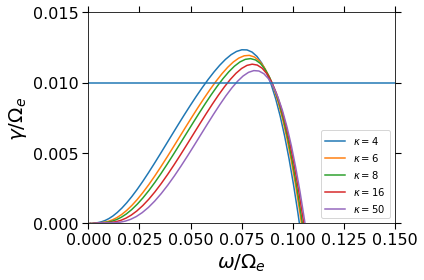

In [29]:
for kappa in [4, 6, 8, 16, 50]:
    shaaban_disp = shaaban_disps[kappa]
    plt.plot(shaaban_disp.real, shaaban_disp.imag, label=f'$\kappa=${kappa}')
plt.axhline(0.01)
plt.ylim([-1e-5, 1.5e-2])
plt.xlim([0, 0.15])
plt.legend()
plt.xlabel(r'$\omega/\Omega_e$')
plt.ylabel(r'$\gamma/\Omega_e$')
plt.tight_layout()
plt.savefig('figure/growth_rate_4_PIC.png', dpi=100)

In [53]:
!open .